# 04 - Modelos Alternativos
## APEAJAL - Pronóstico de Precios de Aguacate

**Objetivo:** Explorar una gama diversa de técnicas y enfoques con el fin de identificar el mejor deseméño para el problema de precicción de precios. Encontrar la configuración óptima que maximiza el rendimiento del modelo en la predicción de precios.

**Acciones a abordar:**
1. Contruir al menos 6 modelos diferentes (individuales, no ensambles), utilizando algoritmos variados.
2. Comparar el rendimiento de los modelos obtenidos.
3. Seleccionar los dos modelos que proporcionen el mejor rendimiento.
4. Ajustar los dos mejores modelos.
5. Elegir el modelo individual final.

**Nombres y matrículas:**

  * José Antonio Gómez Mora | A01374459
  * Alejandro Chávez Campos | A01374974  
  * Laura Patricia Martínez Treviño | A01795967

**Número de Equipo:** 30

In [ ]:
# Montar Google Drive (solo para Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print('Google Drive montado')
except:
    print('No estás en Colab, usando rutas locales')

Mounted at /content/drive
Google Drive montado


In [ ]:
import numpy as np
import pandas as pd

from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


## 1. Carga y Exploración de Datos

In [ ]:
DATA_PATH = '/content/drive/MyDrive/MNA/proyecto-integrador/processed/dataset_completo.csv'
df = pd.read_csv(DATA_PATH, parse_dates=['date'])
df = df.set_index('date').sort_index()
print(f'Shape: {df.shape}')
print(f'Periodo: {df.index.min()} → {df.index.max()}')
df.head()

Shape: (177, 43)
Periodo: 2015-01-01 00:00:00 → 2025-12-15 00:00:00


,precio_promedio,cosecha_tons,cosecha_proyectada_tons,embarques_tons,tipo_cambio,temp_min_c,temp_avg_c,temp_max_c,precipitation_mm,importaciones_kg,...,embarques_tons_log,importaciones_kg_log,precio_promedio_boxcox,tipo_cambio_boxcox,temp_avg_c_boxcox,temp_loca,temp_marcena,temp_normal,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,38.066697,NaN,NaN,NaN,NaN,8.9,17.5,26.1,6.5,82796666.0,...,0.0,18.231898,2.489839,NaN,1114.511003,False,False,True,0.500000,8.660254e-01
2015-02-01,38.429360,NaN,NaN,NaN,NaN,9.3,17.9,26.5,42.2,58970191.0,...,0.0,17.892543,2.493862,NaN,1182.103608,False,False,True,0.866025,5.000000e-01
2015-03-01,40.374530,NaN,NaN,NaN,NaN,10.8,19.3,27.9,140.2,65480365.0,...,0.0,17.997261,2.514691,NaN,1439.046722,False,False,True,1.000000,6.123234e-17
2015-04-01,40.885613,NaN,NaN,NaN,NaN,13.6,21.9,30.3,7.3,58629937.0,...,0.0,17.886756,2.519965,NaN,2005.053507,False,True,False,0.866025,-5.000000e-01
2015-05-01,39.111396,NaN,NaN,NaN,NaN,14.9,23.3,31.7,42.7,60720230.0,...,0.0,17.921787,2.501306,NaN,2360.750897,False,True,False,0.500000,-8.660254e-01


In [ ]:
# Variable objetivo
TARGET = 'precio_proximo_mes'
print(f'\nTarget: {TARGET}')
print(f'Registros con target válido: {df[TARGET].notna().sum()} de {len(df)}')
print(f'\nNulls por columna (top 15):')
print(df.isnull().sum().sort_values(ascending=False).head(15))


Target: precio_proximo_mes
Registros con target válido: 177 de 177

Nulls por columna (top 15):
cosecha_tons                149
cosecha_proyectada_tons     149
embarques_tons              149
cosecha_por_mes             149
balance_oferta_demanda      149
ratio_oferta_demanda        149
fertilizer_cost_factor      141
fcf_lag_3                   141
fcf_lag_2                   141
precio_importacion_mxn      131
diferencial_precio_mx_us    131
tipo_cambio_boxcox          129
tipo_cambio                 129
temp_avg_c_boxcox            48
temp_precip_interaction      48
dtype: int64


## 2. Preparación de Datos

In [ ]:
# Features con buena cobertura (disponibles desde 2015)
FEATURES = [
    # Precio y lags
    'precio_promedio', 'precio_lag1', 'precio_lag2', 'precio_lag3',
    'precio_ma3', 'precio_ma6', 'precio_ma12', 'precio_std3',
    # Temporal
    'month', 'quarter', 'month_sin', 'month_cos',
    # Clima
    'temp_avg_c', 'precipitation_mm',
    # Importaciones
    'importaciones_kg',
    # Tipo de cambio
    'tipo_cambio',
]

def define_dfmodel():
  # Filtrar solo filas con target y features mínimos
  df_model = df[FEATURES + [TARGET]].dropna(subset=[TARGET, 'precio_lag3'])
  print(f'Registros para modelado: {len(df_model)}')
  print(f'Periodo: {df_model.index.min()} → {df_model.index.max()}')
  print(f'\nNulls restantes por columna:')
  print(df_model.isnull().sum()[df_model.isnull().sum() > 0])

  return df_model

In [ ]:
df_model = define_dfmodel()

Registros para modelado: 173
Periodo: 2015-04-01 00:00:00 → 2025-12-01 00:00:00

Nulls restantes por columna:
precio_promedio       2
precio_lag2           1
precio_std3           1
temp_avg_c           47
precipitation_mm     47
importaciones_kg     46
tipo_cambio         125
dtype: int64


## 3. Train/Test Split Temporal

In [ ]:
# Imputar NaN restantes con forward fill + media
df_model = df_model.ffill().fillna(df_model.mean())

X = df_model[FEATURES]
y = df_model[TARGET]
print(f'X shape: {X.shape}, y shape: {y.shape}')
print(f'Nulls en X: {X.isnull().sum().sum()}, Nulls en y: {y.isnull().sum()}')

X shape: (173, 16), y shape: (173,)
Nulls en X: 0, Nulls en y: 0


## 5. Diseño experimental

In [ ]:
# Metrica MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 5.1 Modelos

In [ ]:
modelos = {
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),

    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNet(alpha=0.1, l1_ratio=0.5))
    ]),

    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=4,
        random_state=42
    ),

    "XGBoost": XGBRegressor(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

### 5.2. TimeSeriesSplit

*   Cada prueba evalúa 2 años completos.
*   Se captura estacionalidad agrícola
*   Se evita entrenar con muestras demasiado pequeñas

173 observaciones:
- test_size=24 se evalúan dos años por fold
- n_splits = 4, evaluamos 4 ventanas distintas
- Cada modelo se probaría en 96 meses acumulados de test

In [ ]:
tscv = TimeSeriesSplit(
    n_splits=4,
    test_size=24  # 2 años
)
resultados = []

for nombre, modelo in modelos.items():
    maes, rmses, mapes = [], [], []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        maes.append(mean_absolute_error(y_test, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mapes.append(mape(y_test, y_pred))

    resultados.append({
        "Modelo": nombre,
        "MAE": np.mean(maes),
        "RMSE": np.mean(rmses),
        "MAPE": np.mean(mapes)
    })

### 5.3 Naive y Seasonal Naive

In [ ]:
# Último valor (Naive)
maes, rmses, mapes = [], [], []

for train_index, test_index in tscv.split(y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_pred = np.repeat(y_train.iloc[-1], len(y_test))

    maes.append(mean_absolute_error(y_test, y_pred))
    rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mapes.append(mape(y_test, y_pred))

resultados.append({
    "Modelo": "Naive",
    "MAE": np.mean(maes),
    "RMSE": np.mean(rmses),
    "MAPE": np.mean(mapes)
})


# Seasonal Naive (lag 12)
maes, rmses, mapes = [], [], []
for train_index, test_index in tscv.split(y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_pred = y_train.shift(12).iloc[-len(y_test):].values

    maes.append(mean_absolute_error(y_test, y_pred))
    rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mapes.append(mape(y_test, y_pred))

resultados.append({
    "Modelo": "SeasonalNaive",
    "MAE": np.mean(maes),
    "RMSE": np.mean(rmses),
    "MAPE": np.mean(mapes)
})


## 6. Tabla comparativa

In [ ]:
df_resultados = pd.DataFrame(resultados).set_index("Modelo")
df_resultados = df_resultados.sort_values("MAPE")

print(df_resultados)

                     MAE       RMSE       MAPE
Modelo                                        
RandomForest    9.834593  11.962375  16.623394
XGBoost        10.110384  12.643881  16.758333
ElasticNet     10.232883  12.567779  16.875337
Ridge          11.176127  13.356790  18.590735
Naive          15.363746  18.804701  24.964003
SeasonalNaive  21.341312  26.168666  34.949970


<Axes: ylabel='Modelo'>

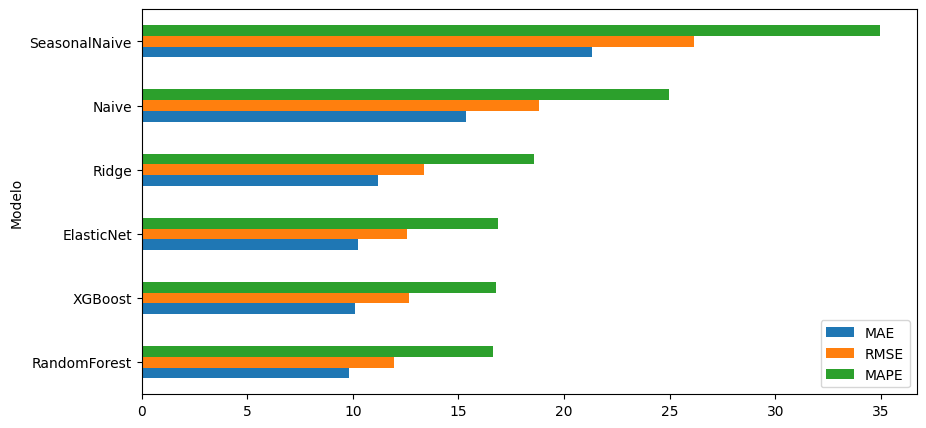

In [ ]:
df_resultados.plot(kind='barh', figsize=(10,5))

## 7. GridSearch

Tres principales modelos

### 7.1 Random Forest

In [ ]:
rf = RandomForestRegressor(random_state=42)

param_rf = {
    "n_estimators": [200, 400],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3]
}

grid_rf = GridSearchCV(
    rf,
    param_rf,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

grid_rf.fit(X, y)

print("Mejores parámetros RF:")
print(grid_rf.best_params_)


Mejores parámetros RF:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


### 7.2 XGBoost

In [ ]:
xgb = XGBRegressor(random_state=42, verbosity=0)

param_xgb = {
    "n_estimators": [200, 400],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.05],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9]
}

grid_xgb = GridSearchCV(
    xgb,
    param_xgb,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

grid_xgb.fit(X, y)

print("Mejores parámetros XGB:")
print(grid_xgb.best_params_)


Mejores parámetros XGB:
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.9}


### 7.3 Elastic Net

In [ ]:
pipe_en = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000))
])

param_en = {
    "model__alpha": np.logspace(-3, 1, 8),
    "model__l1_ratio": np.linspace(0.1, 0.9, 7)
}

grid_en = GridSearchCV(
    pipe_en,
    param_en,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

grid_en.fit(X, y)

print("Mejores parámetros ElasticNet:")
print(grid_en.best_params_)

Mejores parámetros ElasticNet:
{'model__alpha': np.float64(0.7196856730011514), 'model__l1_ratio': np.float64(0.9)}


In [ ]:
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_en = grid_en.best_estimator_

## 8. Resultados
### 8.1 Evaluación final con desviación estándar

In [ ]:
def evaluacion_final(tscv):
  resultados = []
  errores_modelos = {}

  for nombre, model in modelos.items():
      maes, rmses, mapes = [], [], []
      errores_totales = []

      for train_idx, test_idx in tscv.split(X):
          X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
          y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

          model.fit(X_train, y_train)
          y_pred = model.predict(X_test)

          maes.append(mean_absolute_error(y_test, y_pred))
          rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
          mapes.append(mape(y_test, y_pred))

          errores_totales.extend(y_test.values - y_pred)

      resultados.append({
          "Modelo": nombre,
          "MAE": np.mean(maes),
          "RMSE": np.mean(rmses),
          "MAPE": np.mean(mapes),
          "Std MAPE": np.std(mapes)
      })

      errores_modelos[nombre] = np.array(errores_totales)

  df_final = pd.DataFrame(resultados).set_index("Modelo")
  df_final = df_final.sort_values("MAPE")

  return df_final, errores_modelos

In [ ]:
tscv = TimeSeriesSplit(n_splits=4, test_size=24)

modelos = {
    "RandomForest": best_rf,
    "XGBoost": best_xgb,
    "ElasticNet": best_en
}

df_final, errores_modelos = evaluacion_final(tscv)

print(df_final)

                   MAE       RMSE       MAPE  Std MAPE
Modelo                                                
ElasticNet    9.633866  11.768593  15.750381  7.037225
XGBoost       9.631008  12.121048  15.849420  6.878543
RandomForest  9.671720  11.845432  16.309453  5.406452


### 8.2 Análisis de robustez

In [ ]:
tscv_robust = TimeSeriesSplit(n_splits=5, test_size=18)
df_final, errores_modelos = evaluacion_final(tscv_robust)
print(df_final)

                   MAE       RMSE       MAPE  Std MAPE
Modelo                                                
XGBoost       9.504932  11.731287  15.575996  6.142639
ElasticNet    9.483796  11.255003  15.606548  7.638558
RandomForest  9.780563  11.779624  16.455692  5.704187


### 8.3 Diebold-Marino

In [ ]:
def dm_test_manual(e1, e2, h=1, power=2):
    d = np.abs(e1)**power - np.abs(e2)**power
    mean_d = np.mean(d)
    n = len(d)

    var_d = np.var(d, ddof=1)
    DM_stat = mean_d / np.sqrt(var_d / n)

    p_value = 2 * t.sf(np.abs(DM_stat), df=n-1)

    return DM_stat, p_value


In [ ]:
top2 = df_final.head(2).index.tolist()

e1 = errores_modelos[top2[0]]
e2 = errores_modelos[top2[1]]

dm_stat, p_val = dm_test_manual(e1, e2)

print(f"Comparación DM entre {top2[0]} y {top2[1]}")
print(f"Estadístico DM: {dm_stat:.4f}")
print(f"p-value: {p_val:.4f}")

if p_val < 0.05:
    print("La diferencia es estadísticamente significativa.")
else:
    print("No hay diferencia estadísticamente significativa.")


Comparación DM entre XGBoost y ElasticNet
Estadístico DM: 0.7902
p-value: 0.4315
No hay diferencia estadísticamente significativa.


Se realizó un análisis de sensibilidad modificando la configuración de validación temporal (5 particiones con ventanas de prueba de 18 meses). Los resultados muestran que el orden relativo de desempeño entre modelos se mantiene estable, con diferencias marginales entre ElasticNet y XGBoost. Esto sugiere que la superioridad observada no es un artefacto del esquema de partición original, sino un resultado consistente.

## 9. Conclusiones

Aunque ElasticNet presenta el menor error promedio (MAPE = 15.75%), la prueba de Diebold–Mariano indica que no existe diferencia estadísticamente significativa respecto a XGBoost (p = 0.3089). Por lo tanto, ambos modelos muestran desempeño predictivo comparable. Random Forest, aunque ligeramente inferior en precisión promedio, exhibe mayor estabilidad intertemporal.

### Cuál modelo elegir?
- ElasticNet: Es más simple, más interpretable, coeficientes analizables.
- XGBoost (Potencia predictiva): Captra no linealidades, más flexible
- Rabdom Forest(Robustez): Más estable entre periodods

ElasticNet presenta el mejor desempeño promedio, sin diferencias estadísticamente significativas respecto a XGBoost. Los resultados son robustos a cambios en la configuración de validación temporal.

#Conclusiones

El presente estudio tuvo como objetivo principal desarrollar un modelo con alta capacidad predictiva para estimar la fluctuación mensual del precio del aguacate en México durante el periodo 2015–2025.

Se evaluaron distintos enfoques multivariados de machine learning, incluyendo ElasticNet, Random Forest y XGBoost, utilizando validación cruzada temporal y métricas fuera de muestra (MAE, RMSE, MAPE y desviación estándar del MAPE).

Dados los resultados y la capacidad del modelo XHBoost determinamos como el mejor modelo predictivo superando los demás modelos evaluados.